# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
# pip install tensorflow
# pip install graphviz

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.utils import plot_model

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

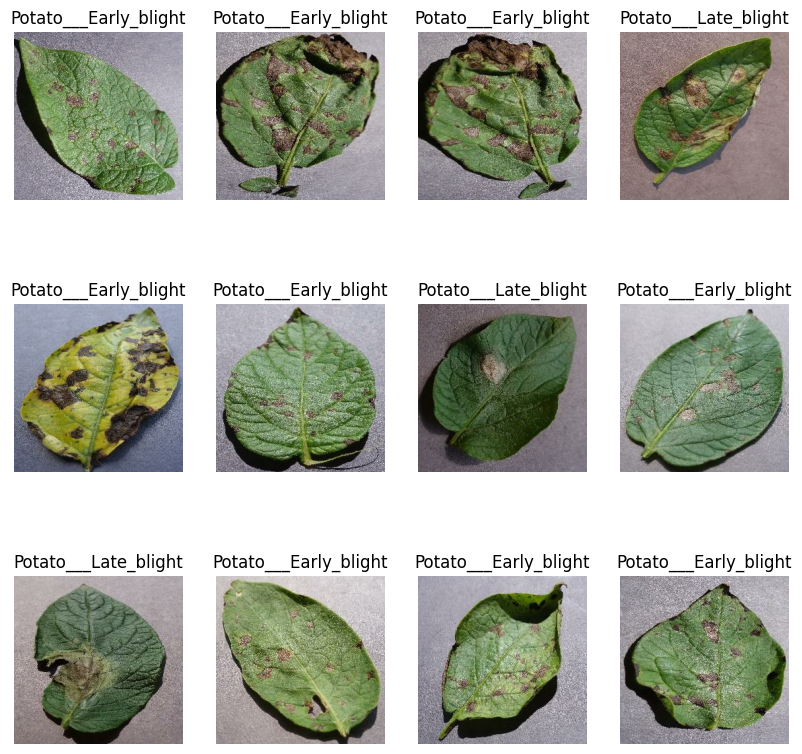

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks**


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (32, 196608)              0         
                                                                 
 dense (Dense)               (32, 64)                  12582976  
                                                                 
 dense_1 (Dense)             (32, 3)                   195       
                                                                 
Total params: 12,583,171
Trainable params: 12,583,171
Non-trainable params: 0
_________________________________________________________________


### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 33s 560ms/step - loss: 4802.6919 - accuracy: 0.5608 - val_loss: 675.2149 - val_accuracy: 0.6458
Epoch 2/10
54/54 [==============================] - 28s 510ms/step - loss: 1374.8240 - accuracy: 0.6117 - val_loss: 1075.3043 - val_accuracy: 0.3438
Epoch 3/10
54/54 [==============================] - 27s 494ms/step - loss: 1541.2286 - accuracy: 0.6013 - val_loss: 814.1284 - val_accuracy: 0.7917
Epoch 4/10
54/54 [==============================] - 27s 496ms/step - loss: 771.7944 - accuracy: 0.7060 - val_loss: 556.2535 - val_accuracy: 0.6406
Epoch 5/10
54/54 [==============================] - 26s 488ms/step - loss: 798.7548 - accuracy: 0.7037 - val_loss: 584.6401 - val_accuracy: 0.7708
Epoch 6/10
54/54 [==============================] - 27s 500ms/step - loss: 772.9987 - accuracy: 0.7014 - val_loss: 298.8688 - val_accuracy: 0.7760
Epoch 7/10
54/54 [==============================] - 27s 506ms/step - loss: 971.0103 - accuracy: 0.7020 - val_loss:

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 19ms/step - loss: 911.3618 - accuracy: 0.6836


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [29]:
scores

[911.36181640625, 0.68359375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [30]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

10

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[4802.69189453125,
 1374.823974609375,
 1541.2286376953125,
 771.79443359375,
 798.7547607421875]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

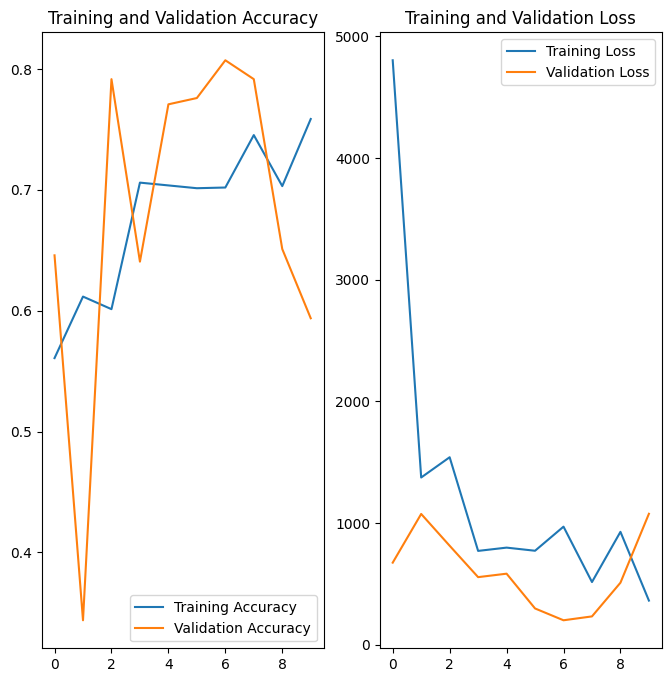

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 188ms/step
predicted label: Potato___Late_blight


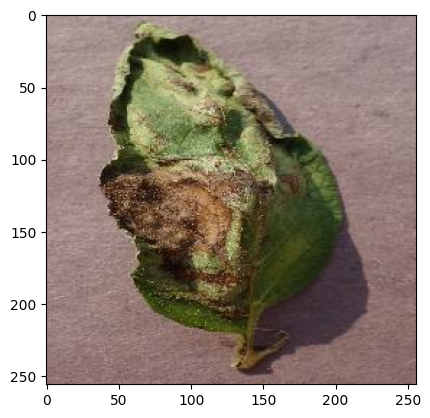

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 31ms/step


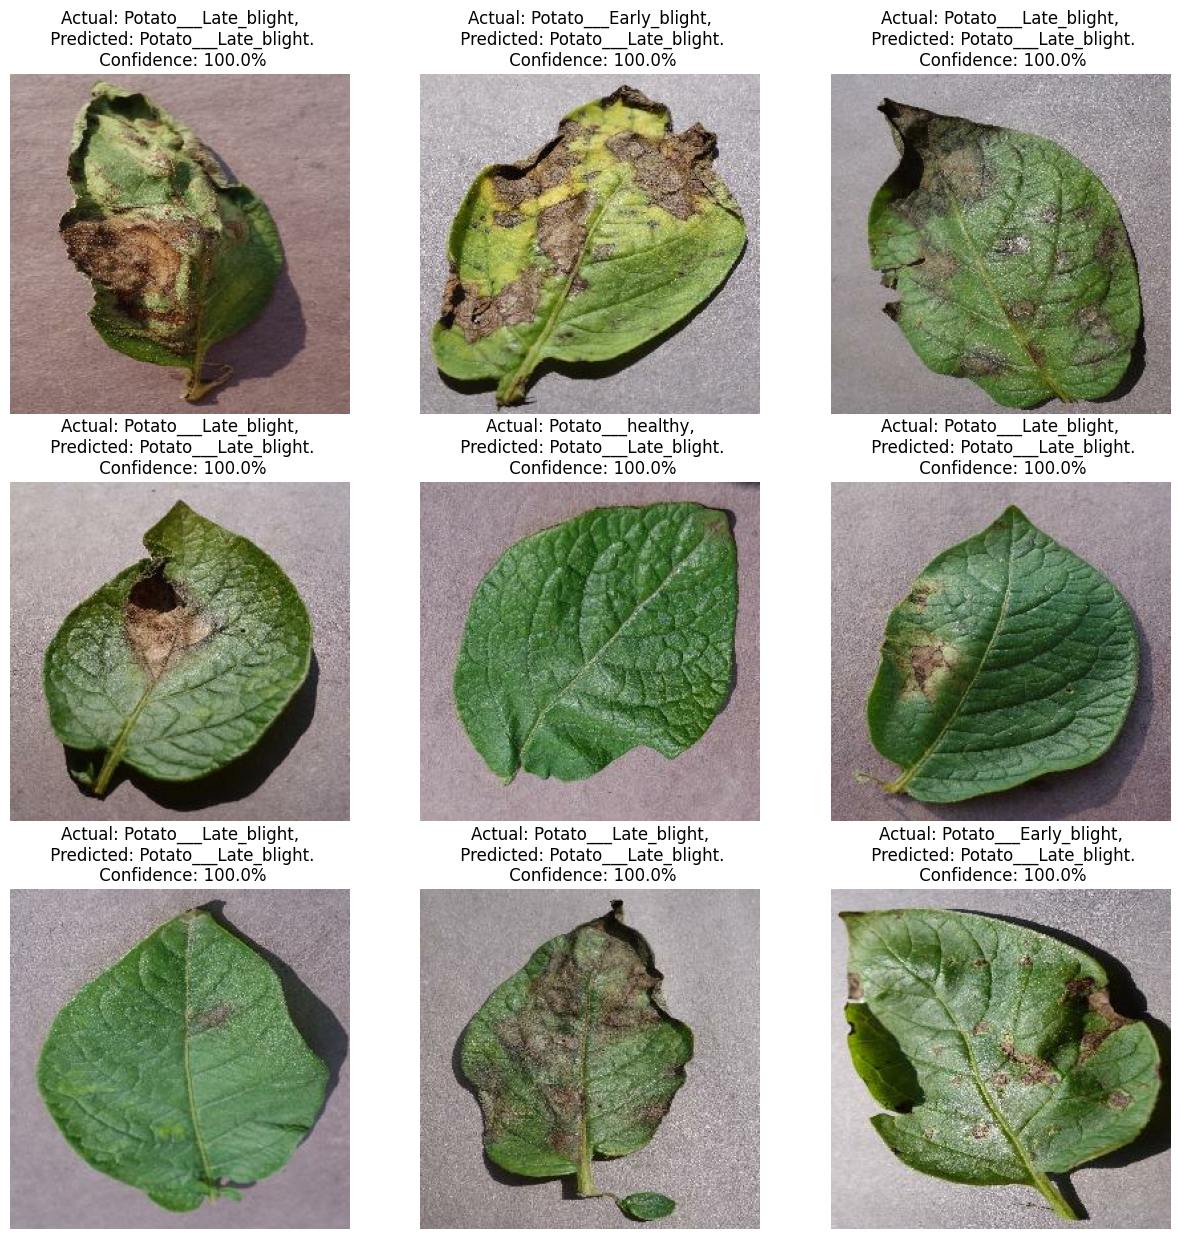

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [41]:
model.save("../potatoes.h5")

### Plotting the model

Plotting the model


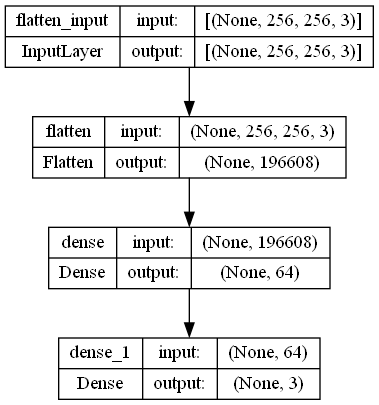

In [42]:
print("Plotting the model")
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [43]:
# get layers in the keras model
potato_model_layers = []
for layer in model.layers:
    potato_model_layers.append(layer.name)
    
# see layers in the keras model
print(potato_model_layers)

['flatten', 'dense', 'dense_1']


In [44]:
# import sys to temporarily add files to sys path 
import sys

# add dir path of the keras2mdf helper function
sys.path.append("C:\\Users\\Rishikesh Maurya\\MDF\\examples\\TensorFlow\\Keras")



# access every function in keras2mdf
from keras2mdf import *

In [45]:
# get the parameters and activation in each dense layer
# use the get_weights_and_activation function from keras2mdf
params, activations = get_weights_and_activation(potato_model_layers[1:], model)

In [51]:
params

{'dense': {'weights': array([[-0.00904743, -0.0031067 , -0.00951459, ..., -0.01064319,
          -0.01000807, -0.00666931],
         [-0.00188887, -0.00619192, -0.00818763, ..., -0.00740536,
          -0.00941519, -0.00130968],
         [-0.005861  , -0.00196844, -0.00421691, ..., -0.00265437,
          -0.00362575,  0.0002923 ],
         ...,
         [-0.01025127, -0.00609865, -0.01015701, ..., -0.00766583,
          -0.0085258 , -0.00606599],
         [-0.00189585, -0.0052787 , -0.01070733, ..., -0.00746683,
          -0.00631259, -0.00942107],
         [-0.00540425, -0.00152838, -0.00599721, ..., -0.00558376,
          -0.00900539, -0.00877381]], dtype=float32),
  'bias': array([-0.00585766, -0.00495509, -0.00600536, -0.00600373, -0.00413257,
          0.00393119, -0.0060053 , -0.00232589, -0.01042574, -0.00600525,
         -0.00599489, -0.00600414,  0.01987188,  0.01178604,  0.        ,
          0.        , -0.00600529, -0.00563859, -0.00501035, -0.00600054,
         -0.00600478,

In [46]:
mdf_model, mdf_model_graph = init_model_with_graph("Potato_disease_prediction", "Potato_disease_prediction_graph")

In [47]:
model.layers[1].input_shape

(None, 196608)

In [55]:
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, (196608,)), y))


In [56]:

# create the input node for the mdf model
input_node = create_input_node("input_node", train_ds.element_spec[0])

# add the input node to the mdf model graph

mdf_model_graph.nodes.append(input_node)

In [57]:
def access_nodes(node_name, graph=mdf_model_graph):
    # convert model to dict
    mdf_dict = mdf_model_graph.to_dict()

    # retrieve keys to access the nodes in mdf_dict
    nested_nodes_dict = mdf_dict["Potato_disease_prediction_graph"]["nodes"]
    
    return nested_nodes_dict[node_name]


In [58]:
weights_h1 = params["dense"]["weights"]
bias_h1 = params["dense"]["bias"]

# create the first dense node for the mdf model
dense_node = create_dense_node("dense_node_1", weights_h1, bias_h1)

# add the dense node to the mdf model graph
mdf_model_graph.nodes.append(dense_node)

In [59]:
# create activation on first dense node
activation_node = create_activation_node("activation_node", activations[0])

# add the activation of the first dense node to the mdf model graph
mdf_model_graph.nodes.append(activation_node)

In [60]:
# get weights and bias for the second dense node
weights_h2 = params["dense_1"]["weights"]
bias_h2 = params["dense_1"]["bias"]

# create the second dense node for the mdf model
dense_node_1 = create_dense_node("dense_node_2", weights_h2, bias_h2)

# add the second dense node to the mdf model graph
mdf_model_graph.nodes.append(dense_node_1)

In [61]:
# create activation on second dense node
output_node = create_activation_node("output_node", activations[1])

# add the activation of the first dense node to the mdf model graph
mdf_model_graph.nodes.append(output_node)

In [62]:

from modeci_mdf.utils import simple_connect
e1 = simple_connect(input_node, dense_node, mdf_model_graph)
e2 = simple_connect(dense_node, activation_node, mdf_model_graph)
e3 = simple_connect(activation_node, dense_node_1, mdf_model_graph)
e4 = simple_connect(dense_node_1, output_node, mdf_model_graph)

Converting MDF graph: Potato_disease_prediction_graph to graphviz (level: 1, format: png)
    Node: input_node
    Node: input_node
    Node: dense_node_1
    Node: activation_node
    Node: dense_node_2
    Node: output_node
    Edge: edge_input_node_dense_node_1 connects input_node to dense_node_1
    Edge: edge_dense_node_1_activation_node connects dense_node_1 to activation_node
    Edge: edge_activation_node_dense_node_2 connects activation_node to dense_node_2
    Edge: edge_dense_node_2_output_node connects dense_node_2 to output_node
Written graph image to: potato-disease-classification-model_mdf.png


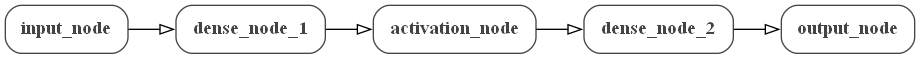

In [63]:
mdf_model.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=1,
        filename_root="potato-disease-classification-model_mdf",
        is_horizontal=True,
        
)
from IPython.display import Image
Image(filename="potato-disease-classification-model_mdf.png")

In [64]:
from modeci_mdf.execution_engine import EvaluableGraph

# create an instance of EvaluableGraph on the graph
eg = EvaluableGraph(mdf_model_graph, verbose=False)
eg.evaluate()


Init graph: Potato_disease_prediction_graph
Evaluating graph: Potato_disease_prediction_graph, root nodes: ['input_node', 'input_node'], with array format numpy


Exception: Error! Could not evaluate expression [(dense_node_1_in @ wgts) + bias] with params [dense_node_1_in=TensorSpec(shape=(196608,), dtype=tf.float32, name=None)(TensorSpec), 
wgts=[[-0.00904743 ... -0.00666931] ... [-0.00540425 ... -0.00877381]] (NP (196608, 64) float32), 
bias=[-0.00585766 ... -0.00501619] (NP (64,) float32), 
Output=0.0,], returned [(dense_node_1_in @ wgts) + bias] which is a <class 'str'>